In [1]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Models and modeling tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

In [3]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')


# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')


# Replace binary columns 1/0
for col in ['default', 'housing', 'loan']:
    features[col].replace({'yes':1,'no':0}, inplace=True)

    
# Encode small categorical columns
cols = ['marital', 'education', 'contact']

enc = OneHotEncoder(sparse=False, dtype=int)
encoded = enc.fit_transform(features[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDF = pd.DataFrame(encoded)
encDF.columns = encNames

features = features.drop(columns=cols)
features = pd.concat([features, encDF], axis=1)


# Encode large categorical columns
cols = ['month', 'job']

enc = OneHotEncoder(sparse=False)
encoded = enc.fit_transform(features[cols])

# There has got to be a better way to do this...
encNames = enc.get_feature_names()
for index, item in enumerate(encNames):
    for i in range(len(cols)):
        encNames[index] = encNames[index].replace('x' + str(i), cols[i])

encDF = pd.DataFrame(encoded)
encDF.columns = encNames

features = features.drop(columns=cols)
features = pd.concat([features, encDF], axis=1)


# Remove duration (this is not a reasonable thing to have in the model as it should tell success/failure well?)
#features = features.drop(columns=['duration'])

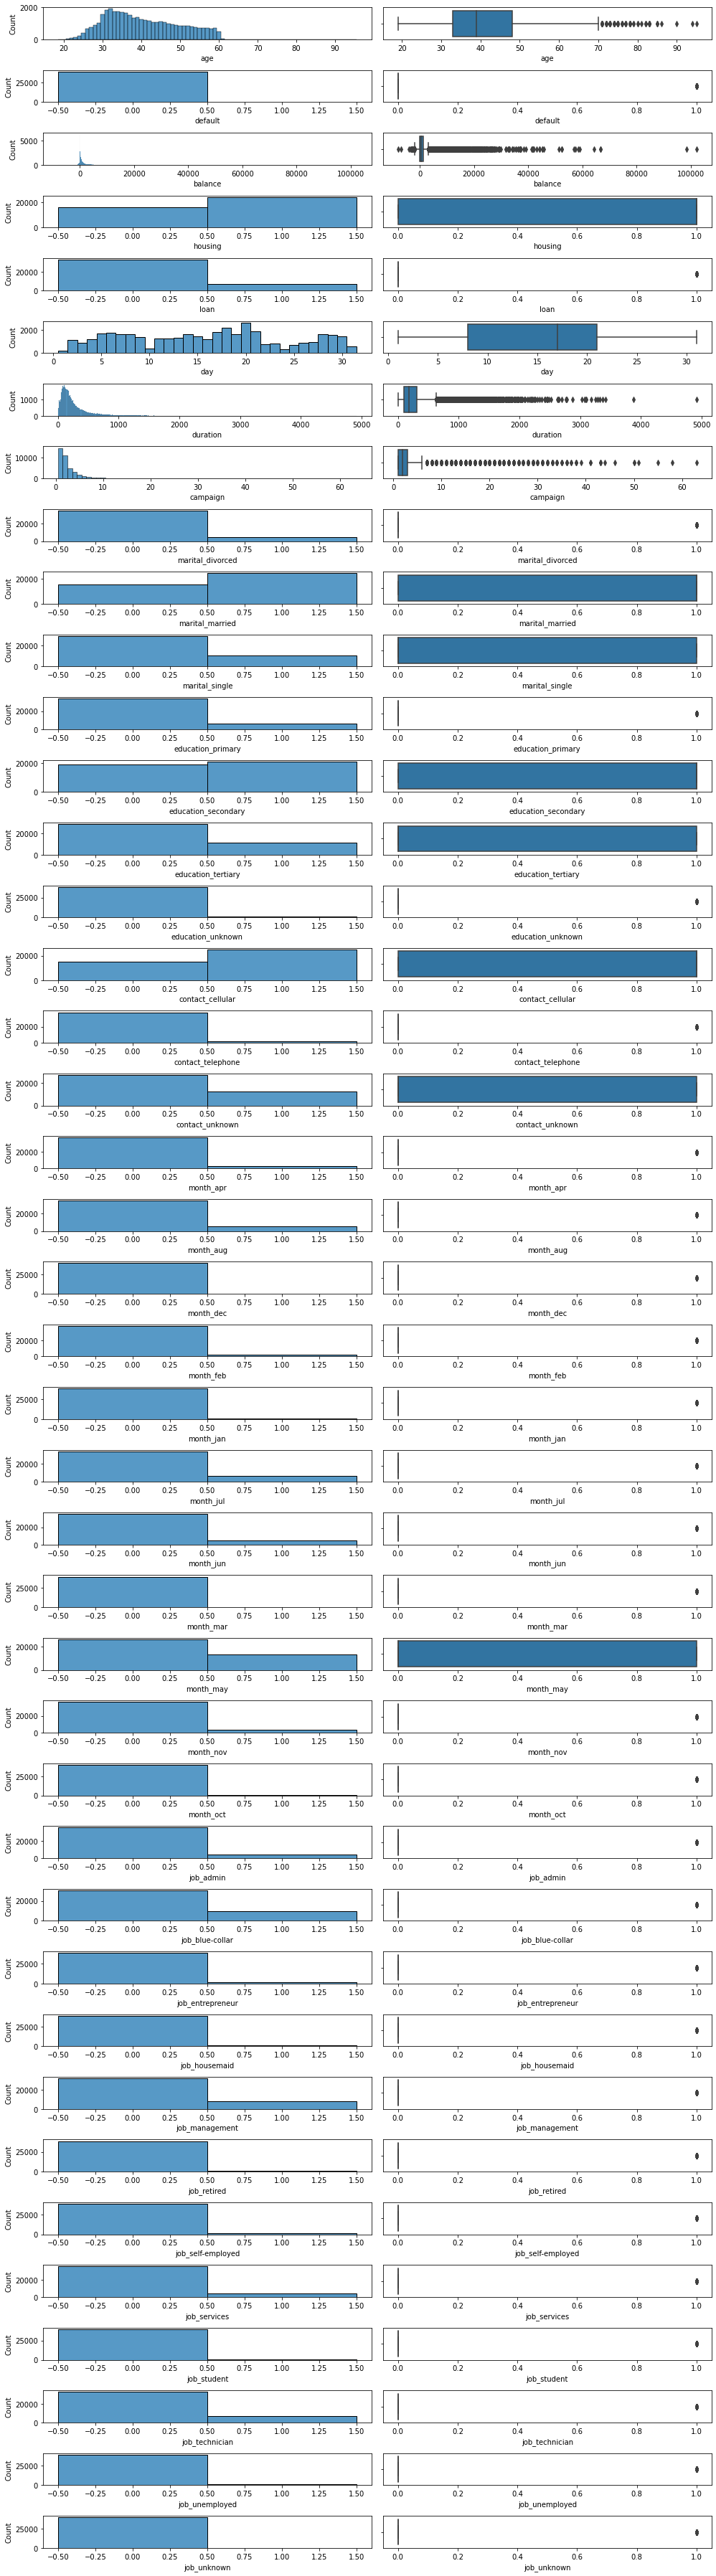

In [4]:
plt.rcParams['figure.figsize'] = [14, 50]

# Plot the feature distributions to look for skewed data/visualize possible outliers
intCols = np.where((features.dtypes == 'int64') | (features.dtypes == 'float'))

fig, axs = plt.subplots(np.size(intCols),2)
cnt = 0
for colID in intCols[0]:
    rnge = features[features.columns[colID]].max() - features[features.columns[colID]].min()
    if (rnge < 100):
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0], discrete=True)
    else:
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0])
    sns.boxplot(data=features, x=features.columns[colID], ax=axs[cnt,1])
    cnt = cnt + 1

plt.tight_layout()
plt.show()

In [5]:
features

,age,default,balance,housing,loan,day,duration,campaign,marital_divorced,marital_married,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,0,2143,1,0,5,261,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44,0,29,1,0,5,151,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,33,0,2,1,1,5,76,1,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,0,1506,1,0,5,92,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,0,1,0,0,5,198,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,0,395,0,0,3,107,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39996,30,0,3340,0,0,3,238,3,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39997,54,0,200,0,0,3,170,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39998,34,0,1047,0,0,3,342,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['balance']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = features[selectedColumns]
y_train = target

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=features[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 52.190000000000005%

Mean decrease in impurity importances:
balance    1.0
dtype: float64


In [186]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['duration']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = features[selectedColumns]
y_train = target

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=features[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 81.69%

Mean decrease in impurity importances:
duration    1.0
dtype: float64


In [8]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['balance']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = ovFeatures[selectedColumns]
y_train = ovTarget

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=ovFeatures[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 58.269999999999996%

Mean decrease in impurity importances:
balance    1.0
dtype: float64


In [9]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['duration']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = ovFeatures[selectedColumns]
y_train = ovTarget

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=ovFeatures[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 86.72%

Mean decrease in impurity importances:
duration    1.0
dtype: float64


In [35]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['balance']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = unFeatures[selectedColumns]
y_train = unTarget

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=unFeatures[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 56.599999999999994%

Mean decrease in impurity importances:
balance    1.0
dtype: float64


In [36]:
#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = ['duration']

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
x_train = unFeatures[selectedColumns]
y_train = unTarget

clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(clf, x_train, y_train, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
clf = clf.fit(x_train, y_train)
importances = pd.Series(clf.feature_importances_, index=unFeatures[selectedColumns].columns)
print ('Mean decrease in impurity importances:')
print (importances.sort_values(ascending=False))

The mean cross-validation score is 86.15%

Mean decrease in impurity importances:
duration    1.0
dtype: float64


In [52]:
oversample = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.75)

steps = [('o', oversample), ('u', under), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = features.columns

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
#x_train = ovFeatures[selectedColumns]
#y_train = ovTarget

#clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
#clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(pipeline, features[selectedColumns], target, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
#clf = clf.fit(x_train, y_train)
#importances = pd.Series(pipeline.feature_importances_, index=features[selectedColumns].columns)
#print ('Mean decrease in impurity importances:')
#print (importances.sort_values(ascending=False))

The mean cross-validation score is 67.46%



In [57]:
oversample = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.75)

steps = [('o', oversample), ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = features.columns

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
#x_train = unFeatures[selectedColumns]
#y_train = unTarget

#clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
#clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(pipeline, features[selectedColumns], target, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
#clf = clf.fit(x_train, y_train)
#importances = pd.Series(clf.feature_importances_, index=features[selectedColumns].columns)
#print ('Mean decrease in impurity importances:')
#print (importances.sort_values(ascending=False))

The mean cross-validation score is 67.19000000000001%



In [58]:
oversample = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.75)

steps = [('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

#selectedColumns = ['age', 'duration', 'balance', 'campaign', 'housing', 'day']
selectedColumns = features.columns

# Separate data in independent (features) and dependent (target) datasets
# Exclude 'OrderCorrect' and 'DeliverySatisfaction' from features due to poor performance
#x_train = unFeatures[selectedColumns]
#y_train = unTarget

#clf = RandomForestClassifier()#(max_depth=9, min_samples_split=2, min_samples_leaf=1, random_state=0)
#clf = clf.fit(x_train, y_train)

# Evaluate model performance
scores = cross_val_score(pipeline, features[selectedColumns], target, scoring='roc_auc', 
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=5))
print (f'The mean cross-validation score is {round(scores.mean(),4)*100}%')
print ()

# Evaluate feature importance
#clf = clf.fit(x_train, y_train)
#importances = pd.Series(clf.feature_importances_, index=features[selectedColumns].columns)
#print ('Mean decrease in impurity importances:')
#print (importances.sort_values(ascending=False))

The mean cross-validation score is 67.83%



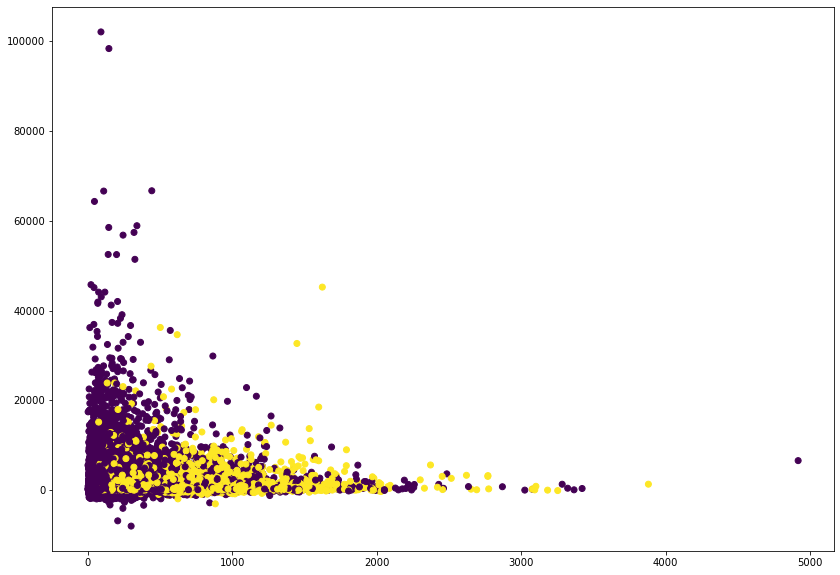

In [71]:
plt.scatter(features['duration'], features['balance'], c=target.replace({'yes':1,'no':0}))

In [88]:
rawData.loc[rawData.duration < 300].y.value_counts()/len(rawData.loc[rawData.duration < 300].y)

no     0.980027
yes    0.019973
Name: y, dtype: float64

In [82]:
rawData.y.value_counts()/len(rawData)

no     0.9276
yes    0.0724
Name: y, dtype: float64

In [107]:
rawData.loc[((rawData.duration > 500) & (rawData.balance < 2000))].y.value_counts() / len(rawData.loc[((rawData.duration > 500) & (rawData.balance < 2000))].y)

no     0.620536
yes    0.379464
Name: y, dtype: float64

In [109]:
rawData.loc[(rawData.duration > 1000)].y.value_counts() / len(rawData.loc[(rawData.duration > 1000)].y)

yes    0.594566
no     0.405434
Name: y, dtype: float64

In [181]:
tmp = rawData[['balance','y']]
durCutoff = 10000
tmp = tmp.replace({'yes':1,'no':0})

tmp['predict'] = np.where(tmp['balance'] > durCutoff, 1, 0)

In [182]:
(tmp['y'] - tmp['predict']).value_counts()

 0    36557
 1     2834
-1      609
dtype: int64

In [183]:
pd.crosstab(index=tmp['y'],columns=tmp['predict'],margins=True, normalize=True)

predict,0,1,All
y,,,
0,0.912375,0.015225,0.9276
1,0.070850,0.001550,0.0724
All,0.983225,0.016775,1.0000


In [32]:
oversample = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.75)
ovFeatures, ovTarget = oversample.fit_resample(features, target)
unFeatures, unTarget = under.fit_resample(ovFeatures, ovTarget)

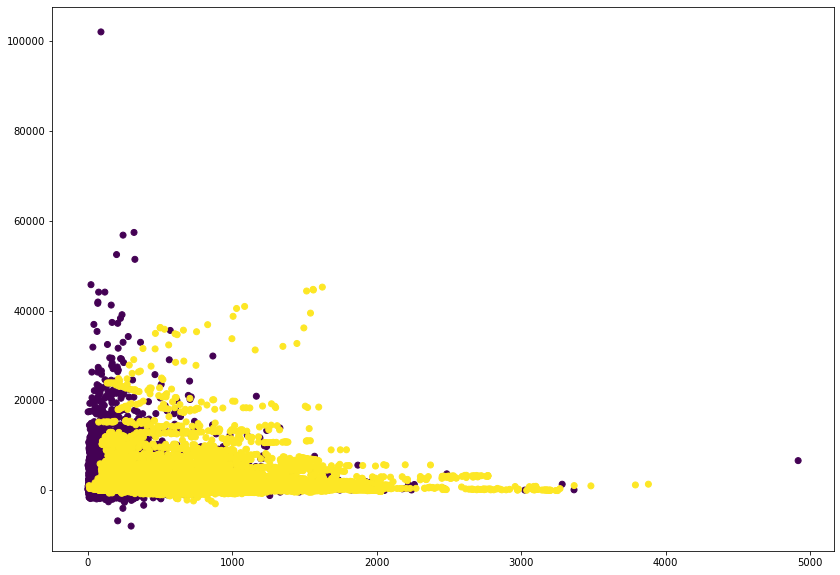

In [33]:
plt.scatter(unFeatures['duration'], unFeatures['balance'], c=unTarget.replace({'yes':1,'no':0}))

In [59]:
target.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

In [64]:
features.loan.value_counts()

0    33070
1     6930
Name: loan, dtype: int64

In [65]:
ovFeatures.loan.value_counts()

0    48371
1     7285
Name: loan, dtype: int64

In [68]:
unFeatures.marital_divorced.value_counts()

0.000000    36161
1.000000     3544
0.054598        1
0.273284        1
0.284000        1
            ...  
0.846177        1
0.429417        1
0.851838        1
0.036864        1
0.479832        1
Name: marital_divorced, Length: 3585, dtype: int64